In [1]:
%matplotlib inline
import csv
import json
import time
import sys
from concurrent.futures import ThreadPoolExecutor

import requests
import mwapi
import mwtypes
import pandas
import seaborn

In [2]:
session = mwapi.Session("https://en.wikipedia.org", user_agent="ahalfaker@wikimedia.org -- IWSC demo")

In [3]:
WEIGHTS = {'Stub': 1, 'Start': 2, 'C': 3, 'B': 4, 'GA': 5, 'FA': 6}
def score2sum(score_doc):
    if score_doc is None:
        return None
    weighted_sum = 0
    for cl, proba in score_doc['probability'].items():
        weighted_sum += WEIGHTS[cl] * proba
    return weighted_sum

In [4]:
def fetch_wp10_score(rev_id):
    response = requests.get('https://ores.wikimedia.org/v3/scores/enwiki/{0}/wp10'.format(rev_id))
    try:
        return response.json()['enwiki']['scores'][str(rev_id)]['wp10']['score']
    except:
        return None


def fetch_wp10_scores(rev_ids):
    executor = ThreadPoolExecutor(max_workers=8)
    return executor.map(fetch_wp10_score, rev_ids)

def fetch_historical_scores(page_name):
    historical_scores = []
    for response_doc in session.get(action='query', prop='revisions', titles=page_name, 
                                    rvprop=['ids', 'timestamp'], rvlimit=100, rvdir="newer", 
                                    formatversion=2, continuation=True):
        rev_docs = response_doc['query']['pages'][0]['revisions']
        rev_ids = [d['revid'] for d in rev_docs]
        for rev_doc, score_doc in zip(rev_docs, fetch_wp10_scores(rev_ids)):
            rev_id = rev_doc['revid']
            timestamp = mwtypes.Timestamp(rev_doc['timestamp'])
            weighted_sum = score2sum(score_doc)
            historical_scores.append({'rev_id': rev_id, 'timestamp': timestamp, 'weighted_sum': weighted_sum})
            sys.stderr.write(".")
            sys.stderr.flush()
        sys.stderr.write("\n")
    
    return historical_scores


In [5]:
historical_scores = pandas.DataFrame(fetch_historical_scores("Ann Bishop (biologist)"))

....................................................................................................
..................................................................................


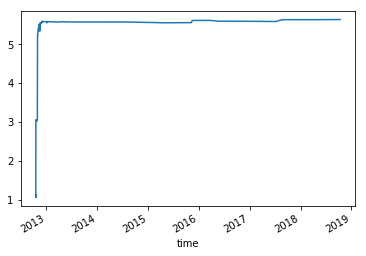

In [6]:
historical_scores['time'] =pandas.to_datetime(historical_scores.timestamp, format='%Y-%m-%dT%H:%M:%SZ',errors='ignore')
historical_scores = historical_scores.set_index('time')
historical_scores['weighted_sum'].plot()

In [7]:
historical_scores2 = pandas.DataFrame(fetch_historical_scores("Tiririca"))

...................................................................


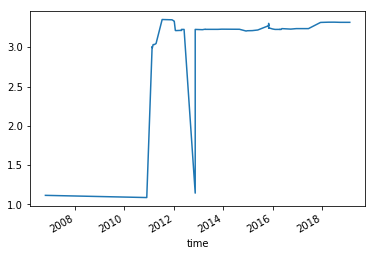

In [8]:
historical_scores2['time'] =pandas.to_datetime(historical_scores2.timestamp, format='%Y-%m-%dT%H:%M:%SZ',errors='ignore')
historical_scores2 = historical_scores2.set_index('time')
historical_scores2['weighted_sum'].plot()

In [9]:
historical_scores2 = pandas.DataFrame(fetch_historical_scores("Ada Lovelace"))

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

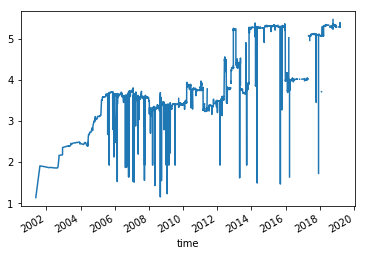

In [10]:
historical_scores2['time'] =pandas.to_datetime(historical_scores2.timestamp, format='%Y-%m-%dT%H:%M:%SZ',errors='ignore')
historical_scores2 = historical_scores2.set_index('time')
historical_scores2['weighted_sum'].plot()

In [11]:
historical_scores2

,rev_id,timestamp,weighted_sum
time,,,
2001-05-20 14:57:05,233871,2001-05-20T14:57:05Z,1.143507
2001-08-17 00:31:59,234424,2001-08-17T00:31:59Z,1.911449
2001-11-18 04:34:16,429658362,2001-11-18T04:34:16Z,1.894739
2002-02-25 15:51:15,48310,2002-02-25T15:51:15Z,1.868932
2002-04-08 12:22:01,96589,2002-04-08T12:22:01Z,1.874799
2002-06-16 14:25:00,141223,2002-06-16T14:25:00Z,1.862681
2002-08-06 10:15:58,179835,2002-08-06T10:15:58Z,1.862681
2002-08-28 16:40:11,204583,2002-08-28T16:40:11Z,1.862681
2002-09-08 22:45:18,319842,2002-09-08T22:45:18Z,1.896889
